Downloaded from where again? 

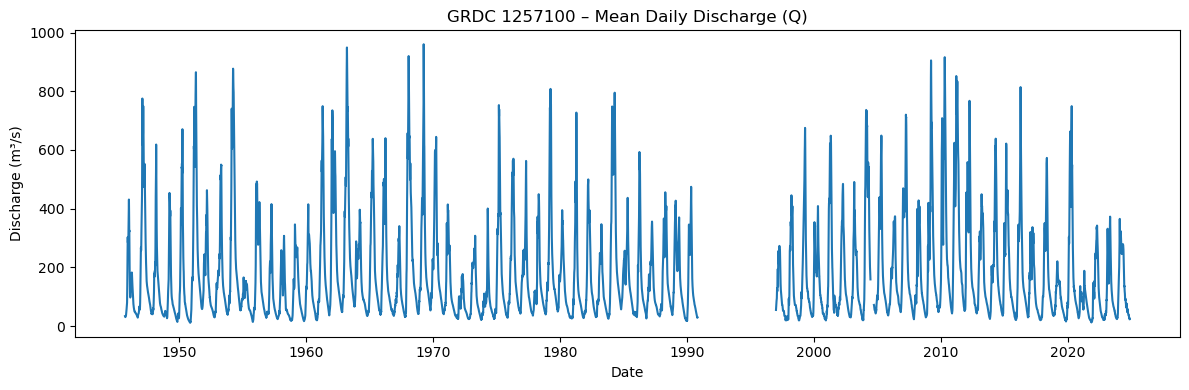

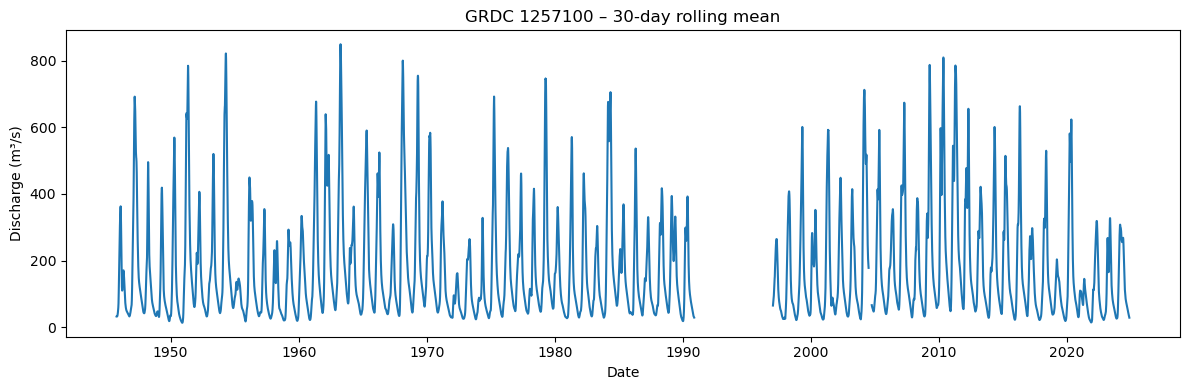

In [5]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# ---- file path (edit as needed) ----
path = Path("../GRDC_station_data/1257100_Q_Day.Cmd.txt")

# ---- read ----
df = pd.read_csv(
    path,
    sep=";",                 # semicolon-delimited
    comment="#",             # skip metadata/header lines starting with '#'
    skipinitialspace=True,   # handles "YYYY-MM-DD;hh:mm; Value" / padded numbers
    encoding="latin-1",      # avoids UnicodeDecodeError from superscripts like ³, ²
    na_values=[-999.000, "-999.000"],  # missing sentinel
)


# Clean column names (e.g., " Value" -> "Value")
df.columns = [c.strip() for c in df.columns]

# Ensure numeric values
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

# Build a datetime index.
# For daily data, hh:mm is often "--:--" (unknown), so map it to midnight.
time_str = df["hh:mm"].astype(str).replace({"--:--": "00:00"})
df["datetime"] = pd.to_datetime(
    df["YYYY-MM-DD"].astype(str) + " " + time_str,
    errors="coerce",
)

# Index by datetime and sort
df = df.dropna(subset=["datetime"]).set_index("datetime").sort_index()

q = df["Value"]  # discharge (m³/s)

# ---- plot 1: raw daily series ----
plt.figure(figsize=(12, 4))
plt.plot(q.index, q.values)
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("GRDC 1257100 – Mean Daily Discharge (Q)")
plt.tight_layout()
plt.show()

# ---- plot 2 (optional): smoothed curve (30-day rolling mean) ----
plt.figure(figsize=(12, 4))
plt.plot(q.index, q.rolling(30, min_periods=10).mean())
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("GRDC 1257100 – 30-day rolling mean")
plt.tight_layout()
plt.show()


---- METADATA ----
Altitude (m ASL): 1000
Catchment area (km²): 410000
Country: BW
Data Set Content: MEAN DAILY DISCHARGE (Q)
Data lines: 17973
Field delimiter: ;
Format: DOS-ASCII
GRDC-No.: 1357100
Last update: 2025-05-27
Latitude (DD): -18.283333
Longitude (DD): 21.8
Next downstream station: -
No. of years: 51
Owner of original data: Botswana - Department of Water and Sanitation
Remarks: 
River: OKAVANGO RIVER
Station: MOHEMBO/MTAEMBO (67932112)
Table Header: 
Time series: 1974-12 - 2024-02
Title: GRDC STATION DATA FILE
Unit of measure: m³/s
_date_max: 2024-02-17
_date_min: 1974-12-04
_file_mtime_utc: 2025-11-13 06:48:16+00:00
_file_name: 1357100_Q_Day.Cmd.txt
_file_size_bytes: 540409
_missing_values: 2014
_rows_read: 17973
file generation date: 2025-11-13


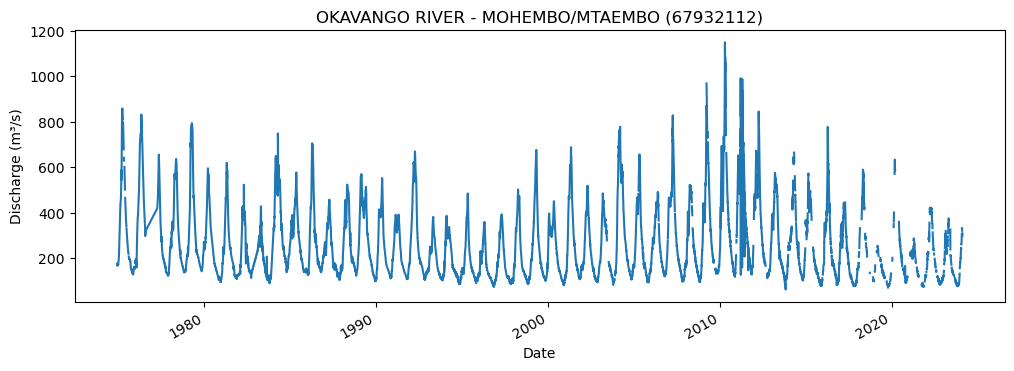

In [6]:
from __future__ import annotations

from pathlib import Path
import re
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MISSING_SENTINEL = -999.000


def extract_grdc_metadata(path: str | Path, encoding: str = "cp1252") -> dict:
    """
    Extract key/value metadata from the GRDC header (lines starting with '#').

    Notes:
      - This file contains superscript chars like 'm³/s' and 'km²'. In practice,
        'cp1252' or 'latin1' is usually safe for these GRDC text exports.
    """
    path = Path(path)
    meta: dict = {}
    header_lines: list[str] = []

    # Read header lines (start with '#') until the first non-header line
    with path.open("r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                break
            header_lines.append(line.rstrip("\n"))

    meta["_raw_header"] = header_lines  # keep if you want to inspect the full header

    # Parse "# Key: Value" lines
    kv_re = re.compile(r"^#\s*([^:]+):\s*(.*)$")
    for ln in header_lines:
        # Ignore indented comment lines (e.g. table header lines like "#     hh:mm - Time")
        if re.match(r"^#\s{2,}\S", ln):
            continue

        m = kv_re.match(ln)
        if not m:
            continue

        key = m.group(1).strip()
        val = re.sub(r"\s{2,}", " ", m.group(2).strip())  # collapse multiple spaces
        meta[key] = val

    # Light type coercions for common numeric/date fields
    def maybe_number(x: str):
        try:
            n = float(x)
            return int(n) if n.is_integer() else n
        except Exception:
            return x

    for k in [
        "GRDC-No.",
        "Next downstream station",
        "Data lines",
        "No. of years",
        "Latitude (DD)",
        "Longitude (DD)",
        "Catchment area (km²)",
        "Altitude (m ASL)",
    ]:
        if k in meta:
            meta[k] = maybe_number(str(meta[k]))

    for k in ["file generation date", "Last update"]:
        if k in meta:
            try:
                meta[k] = date.fromisoformat(str(meta[k]))
            except Exception:
                pass

    # Optional: include filesystem-level metadata too
    st = path.stat()
    meta["_file_name"] = path.name
    meta["_file_size_bytes"] = st.st_size
    meta["_file_mtime_utc"] = pd.to_datetime(st.st_mtime, unit="s", utc=True)

    return meta


def read_grdc_timeseries(path: str | Path, encoding: str = "cp1252") -> pd.DataFrame:
    """
    Read the GRDC data section into a DataFrame with a DatetimeIndex.
    """
    path = Path(path)

    df = pd.read_csv(path, sep=";", comment="#", encoding=encoding)
    df.columns = [c.strip() for c in df.columns]  # e.g. " Value" -> "Value"

    # Convert value and apply missing sentinel
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce").replace(MISSING_SENTINEL, np.nan)

    # For daily values GRDC often uses "--:--" in the time column; treat it as midnight.
    time = df["hh:mm"].astype(str).str.strip().replace({"--:--": "00:00"})

    df["datetime"] = pd.to_datetime(
        df["YYYY-MM-DD"].astype(str).str.strip() + " " + time,
        errors="coerce",
    )

    df = df.dropna(subset=["datetime"]).set_index("datetime").sort_index()
    return df


def plot_grdc_timeseries(df: pd.DataFrame, meta: dict) -> None:
    """
    Simple timeseries plot.
    """
    unit = meta.get("Unit of measure", "")
    river = meta.get("River", "")
    station = meta.get("Station", "")
    title = " - ".join([x for x in [river, station] if x])

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df["Value"])
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Discharge ({unit})" if unit else "Discharge")
    if title:
        ax.set_title(title)
    fig.autofmt_xdate()
    plt.show()


if __name__ == "__main__":
    PATH = "../GRDC_station_data/1357100_Q_Day.Cmd.txt"  # <- change if needed

    meta = extract_grdc_metadata(PATH)
    df = read_grdc_timeseries(PATH)

    # Add a few derived metadata fields from the actual data read
    meta["_rows_read"] = len(df)
    meta["_missing_values"] = int(df["Value"].isna().sum())
    meta["_date_min"] = df.index.min().date().isoformat()
    meta["_date_max"] = df.index.max().date().isoformat()

    # Print metadata (skip the raw header unless you want it)
    print("---- METADATA ----")
    for k in sorted([k for k in meta.keys() if k != "_raw_header"]):
        print(f"{k}: {meta[k]}")

    # Plot
    plot_grdc_timeseries(df, meta)


Loaded 23 files
             source_file  grdc_no     station_name country        lat  \
0  1257100_Q_Day.Cmd.txt  1257100            RUNDU      NA -17.900000   
1  1257101_Q_Day.Cmd.txt  1257101            MUKWE      NA -18.033333   
2  1257200_Q_Day.Cmd.txt  1257200           OUSEMA      NA -21.216667   
3  1357100_Q_Day.Cmd.txt  1357100  MOHEMBO/MTAEMBO      BW -18.283333   
4  1357200_Q_Day.Cmd.txt  1357200    SHASHE BRIDGE      BW -20.016667   

         lon  
0  19.750000  
1  21.416667  
2  17.100000  
3  21.800000  
4  23.383333  


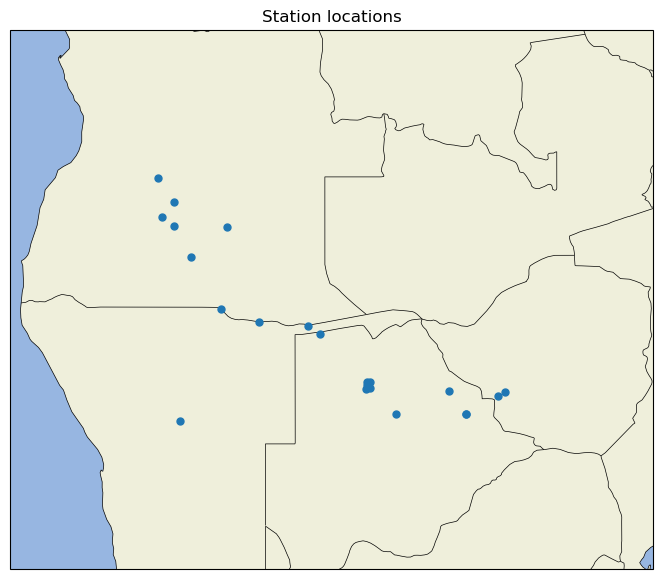

Saved timeseries plots to: grdc_timeseries_plots/


In [7]:
from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Optional: only needed for the world basemap.
# If you already used geopandas for your map, keep it.
import geopandas as gpd


META_RE = re.compile(r"^#\s*(?P<key>[^:]+):\s*(?P<val>.*)\s*$")

def _to_float(x) -> float:
    """Robust float parsing (handles commas, whitespace, None)."""
    if x is None:
        return np.nan
    s = str(x).strip().replace(",", ".")
    return pd.to_numeric(s, errors="coerce")


def _parse_filename(fp: Path) -> dict:
    """
    Many GRDC files look like: 1257100_Q_Day.Cmd.txt
    We'll try to extract station id + variable tag from that.
    """
    m = re.match(r"^(?P<id>\d+)_(?P<tag>.+?)\.Cmd\.txt$", fp.name)
    if not m:
        return {"file_station_id": np.nan, "file_tag": fp.stem}
    return {
        "file_station_id": pd.to_numeric(m.group("id"), errors="coerce"),
        "file_tag": m.group("tag"),
    }


def read_grdc_cmd_file(fp: str | Path, encoding: str = "latin-1") -> tuple[dict, pd.DataFrame]:
    """
    Returns:
      meta: dict of metadata (raw + standardized fields)
      ts:   DataFrame with DatetimeIndex and numeric columns
    """
    fp = Path(fp)

    # --------- metadata (header) ----------
    meta_raw = {"source_file": fp.name, "source_path": str(fp)}
    meta_raw.update(_parse_filename(fp))

    with open(fp, "r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                continue
            m = META_RE.match(line)
            if m:
                meta_raw[m.group("key").strip()] = m.group("val").strip()

    # Standardize a few common keys (keep raw keys too)
    keymap = {
        "GRDC-No.": "grdc_no",
        "River": "river",
        "Station": "station_raw",
        "Country": "country",
        "Latitude (DD)": "lat",
        "Longitude (DD)": "lon",
        "Catchment area (km²)": "catchment_area_km2",
        "Catchment area (km�)": "catchment_area_km2",
        "Catchment area (km\xb2)": "catchment_area_km2",  # sometimes shows up like this
        "Altitude (m ASL)": "altitude_m",
        "file generation date": "file_generation_date",
        "Data lines": "data_lines",
    }
    meta = dict(meta_raw)  # copy

    for raw_k, std_k in keymap.items():
        if raw_k in meta_raw:
            meta[std_k] = meta_raw[raw_k]

    # Station name/code split like: "RUNDU (64932101)"
    if isinstance(meta.get("station_raw"), str):
        m = re.match(r"^(.*?)\s*\((.*?)\)\s*$", meta["station_raw"])
        if m:
            meta["station_name"] = m.group(1).strip()
            meta["station_code"] = m.group(2).strip()
        else:
            meta["station_name"] = meta["station_raw"].strip()

    # Numeric conversions (important for plotting)
    if "grdc_no" in meta:
        meta["grdc_no"] = pd.to_numeric(str(meta["grdc_no"]).strip(), errors="coerce")
    for k in ("lat", "lon", "catchment_area_km2", "altitude_m"):
        if k in meta:
            meta[k] = _to_float(meta[k])
    if "data_lines" in meta:
        meta["data_lines"] = pd.to_numeric(str(meta["data_lines"]).strip(), errors="coerce")

    # --------- time series table ----------
    # Use latin-1 to avoid UnicodeDecodeError from header chars (e.g., km²)
    df = pd.read_csv(
        fp,
        sep=";",
        comment="#",
        skip_blank_lines=True,
        dtype=str,
        encoding=encoding,
    )

    # Clean column names + strip whitespace
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()

    date_col = df.columns[0]
    time_col = df.columns[1] if len(df.columns) >= 2 else None

    # IMPORTANT: specify format to avoid your warnings
    date = pd.to_datetime(df[date_col], format="%Y-%m-%d", errors="coerce")

    if time_col is not None and (df[time_col] != "--:--").any():
        # Files with actual times:
        t = df[time_col].replace({"--:--": "00:00"})
        dt = pd.to_datetime(df[date_col] + " " + t, format="%Y-%m-%d %H:%M", errors="coerce")
    else:
        # Daily files:
        dt = date

    # Convert remaining columns to numeric (and set missing flags to NaN)
    drop_cols = [date_col] + ([time_col] if time_col is not None else [])
    data_cols = [c for c in df.columns if c not in drop_cols]

    out = df[data_cols].replace(
        {"-999.000": np.nan, "-999": np.nan, "": np.nan, "nan": np.nan}
    )
    for c in data_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out.insert(0, "datetime", dt)
    out = out.dropna(subset=["datetime"]).set_index("datetime").sort_index()

    return meta, out


def load_grdc_folder(folder: str | Path, pattern: str = "*.Cmd.txt") -> tuple[pd.DataFrame, dict]:
    """
    Returns:
      meta_df: one row per file
      ts_dict: dict keyed by (grdc_no, file_tag, source_file) -> DataFrame
    """
    folder = Path(folder)
    files = sorted(folder.glob(pattern))

    meta_rows = []
    ts_dict = {}

    for fp in files:
        meta, ts = read_grdc_cmd_file(fp)

        meta_rows.append(meta)

        # Key by station + tag + filename to avoid overwriting if multiple files per station
        grdc_no = meta.get("grdc_no", meta.get("file_station_id"))
        tag = meta.get("file_tag", fp.stem)
        ts_dict[(grdc_no, tag, fp.name)] = ts

    meta_df = pd.DataFrame(meta_rows)

    # Helpful: prefer grdc_no if pZresent
    if "grdc_no" in meta_df.columns:
        meta_df = meta_df.sort_values(["grdc_no", "source_file"], na_position="last").reset_index(drop=True)

    return meta_df, ts_dict

def plot_station_map(meta_df):
    stations = meta_df.dropna(subset=["lat", "lon"]).copy()

    fig, ax = plt.subplots(
        figsize=(10, 7),
        subplot_kw={"projection": ccrs.PlateCarree()}  
    )

    # Basemap features (no geopandas needed)
    ax.add_feature(cfeature.LAND, linewidth=0.2)
    ax.add_feature(cfeature.OCEAN, linewidth=0.2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    pad = 5
    lon_min = stations["lon"].min() - pad
    lon_max = stations["lon"].max() + pad
    lat_min = stations["lat"].min() - pad
    lat_max = stations["lat"].max() + pad

    #  now this works
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # IMPORTANT with cartopy: supply transform=
    ax.scatter(
        stations["lon"], stations["lat"],
        s=25,
        transform=ccrs.PlateCarree(),
        zorder=3
    )

    ax.set_title("Station locations")
    return fig, ax


def plot_timeseries_per_station(meta_df: pd.DataFrame, 
                                ts_dict: dict, 
                                out_dir: str | Path | None = None):
    """
    One figure per station (GRDC-No.). If multiple files per station, they are overlaid.
    """
    # Group dict entries by station id
    by_station = {}
    for (grdc_no, tag, fname), ts in ts_dict.items():
        by_station.setdefault(grdc_no, []).append((tag, fname, ts))

    if out_dir is not None:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)

    # Build a quick lookup for station name
    name_lookup = {}
    if "grdc_no" in meta_df.columns and "station_name" in meta_df.columns:
        for _, r in meta_df.dropna(subset=["grdc_no"]).iterrows():
            if pd.notna(r.get("station_name")):
                name_lookup[r["grdc_no"]] = r["station_name"]

    for grdc_no, series_list in by_station.items():
        
        fig, ax = plt.subplots(figsize=(14, 4))

        for (tag, fname, ts) in sorted(series_list, key=lambda x: str(x[0])):
            # Plot all numeric columns in this file
            numeric_cols = [c for c in ts.columns if pd.api.types.is_numeric_dtype(ts[c])]
            if not numeric_cols:
                continue
            ts[numeric_cols].plot(ax=ax, linewidth=0.8, label=[f"{tag}:{c}" for c in numeric_cols])

        station_name = name_lookup.get(grdc_no, "")
        title = f"GRDC {int(grdc_no) if pd.notna(grdc_no) else grdc_no}"
        if station_name:
            title += f" — {station_name}"
        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.grid(True, linewidth=0.2)

        # If there are many overlays, legend can get huge; toggle as you like:
        ax.legend(loc="best", fontsize=8, ncols=2)

        fig.tight_layout()

        if out_dir is not None:
            safe_id = "unknown" if pd.isna(grdc_no) else str(int(grdc_no))
            fig.savefig(out_dir / f"{safe_id}_timeseries.png", dpi=150)
            plt.close(fig)  # avoid 100s of open figures in notebooks


# --------------------
# RUN IT
# --------------------
DATA_DIR = Path("../GRDC_station_data")

meta_df, ts_dict = load_grdc_folder(DATA_DIR, pattern="*.Cmd.txt")

print(f"Loaded {len(meta_df)} files")
print(meta_df[["source_file", "grdc_no", "station_name", "country", "lat", "lon"]].head())

# Map (points should now appear)
fig, ax = plot_station_map(meta_df)
plt.show()

# Time series plots (set out_dir to save images)
plot_timeseries_per_station(meta_df, ts_dict, out_dir="grdc_timeseries_plots")
print("Saved timeseries plots to: grdc_timeseries_plots/")


In [8]:
import ee
import geemap
import geopandas as gpd

# --- EE init (authenticate once, then ee.Initialize() will work afterwards) ---
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

stations = meta_df
# --- build a ROI from your station extent (add padding so rivers aren't cut off) ---
min_lon = float(stations["lon"].min())
max_lon = float(stations["lon"].max())
min_lat = float(stations["lat"].min())
max_lat = float(stations["lat"].max())

pad_deg = 5.0  # tweak as needed
roi = ee.Geometry.Rectangle([min_lon - pad_deg, min_lat - pad_deg,
                            max_lon + pad_deg, max_lat + pad_deg])

# --- load & clip rivers ---
rivers_fc = (ee.FeatureCollection("WWF/HydroSHEDS/v1/FreeFlowingRivers")
             .filter(ee.Filter.lt('RIV_ORD', 7))
             .filterBounds(roi))

# OPTIONAL (recommended if it’s too dense): simplify geometry a bit (meters)
rivers_fc = rivers_fc.map(lambda f: f.simplify(500))

# --- convert to GeoDataFrame (function name depends on geemap version) ---
try:
    rivers_gdf = geemap.ee_to_geopandas(rivers_fc)
except AttributeError:
    rivers_gdf = geemap.ee_to_gdf(rivers_fc)  # older geemap versions

# set CRS (EE vectors are lon/lat)
rivers_gdf = rivers_gdf.set_crs("EPSG:4326", allow_override=True)



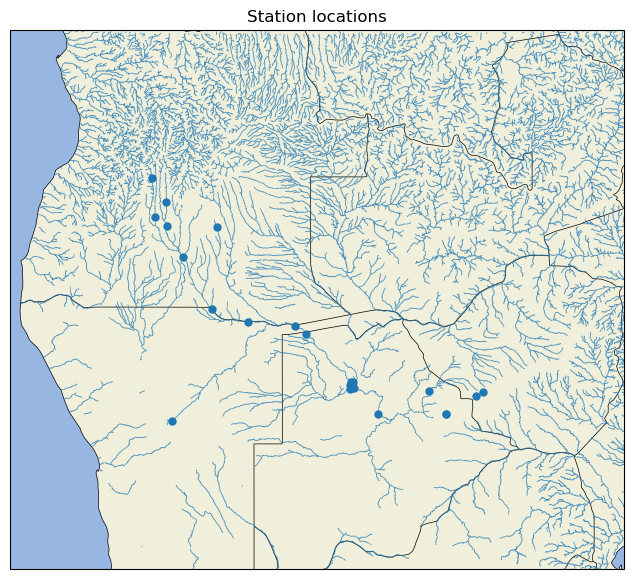

Saved timeseries plots to: grdc_timeseries_plots/


In [9]:
# Map (points should now appear)
fig, ax = plot_station_map(meta_df)

rivers_gdf.plot(
    ax=ax,
    linewidth=0.6,
    alpha=0.8,
    zorder=2
)

plt.show()

# Time series plots (set out_dir to save images)
plot_timeseries_per_station(meta_df, ts_dict, out_dir="grdc_timeseries_plots")
print("Saved timeseries plots to: grdc_timeseries_plots/")



Saved: mohembo_1357100_Q_daily.csv  |  rows=17973  |  range=1974-12-04 → 2024-02-17


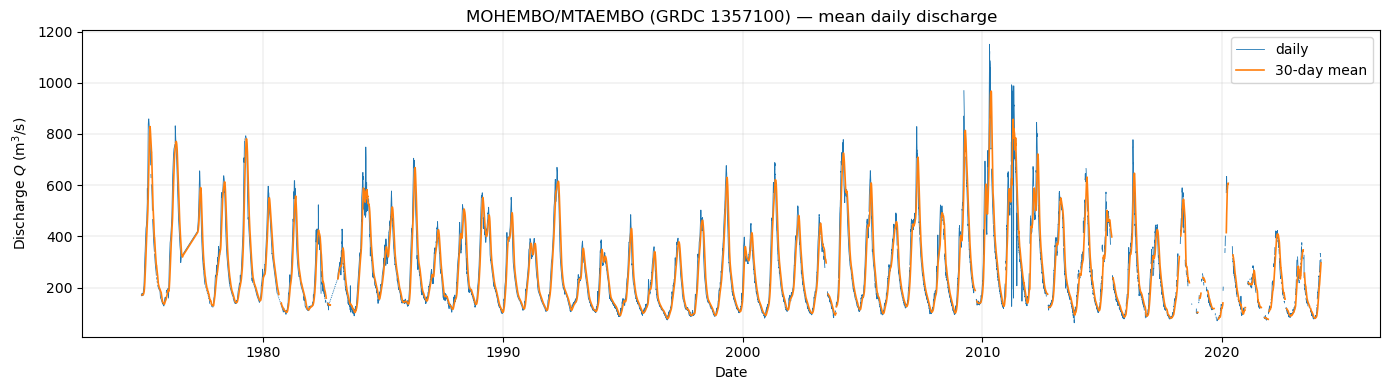

In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("../GRDC_station_data")
fp = DATA_DIR / "1357100_Q_Day.Cmd.txt"

meta, ts = read_grdc_cmd_file(fp)

# pick the discharge column (first numeric column) and standardize its name
q_col = next(c for c in ts.columns if pd.api.types.is_numeric_dtype(ts[c]))
ts = ts.rename(columns={q_col: "Q_m3s"})

# add year/month columns (handy for aggregations)
ts = ts.assign(
    year=ts.index.year,
    month=ts.index.month,
    grdc_no=int(meta["grdc_no"]) if pd.notna(meta.get("grdc_no")) else None,
    station=meta.get("station_name", "MOHEMBO/MTAEMBO"),
)

# export (daily)
out_csv = Path("../data/mohembo_1357100_Q_daily.csv")
ts[["Q_m3s", "year", "month", "grdc_no", "station"]].to_csv(out_csv, index_label="date")
print(f"Saved: {out_csv}  |  rows={len(ts)}  |  range={ts.index.min().date()} → {ts.index.max().date()}")

# plot (daily hydrograph + light smoothing)
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(ts.index, ts["Q_m3s"], linewidth=0.6, label="daily")

q_roll = ts["Q_m3s"].rolling("30D", min_periods=10).mean()
ax.plot(q_roll.index, q_roll, linewidth=1.2, label="30-day mean")

ax.set_title(f"{meta.get('station_name','MOHEMBO/MTAEMBO')} (GRDC {int(meta['grdc_no'])}) — mean daily discharge")
ax.set_xlabel("Date")
ax.set_ylabel(r"Discharge $Q$ (m$^3$/s)")
ax.grid(True, linewidth=0.2)
ax.legend()
fig.tight_layout()
plt.show()
